## Dataset analysis

In [45]:
import sys
import json
import pandas as pd
from pathlib import Path

project_root = Path.cwd().parent  # Move up from notebooks/ to project root
sys.path.append(str(project_root))

from src.constants import drivelm_train_json, drivelm_test_json, drivelm_val_json


def load_dataset(path):
    with open(path, "r") as f:
        return json.load(f)


datasets = {
    "train": load_dataset(drivelm_train_json),
    "test": load_dataset(drivelm_test_json),
    "eval": load_dataset(drivelm_val_json),
}


def extract_questions(dataset, dataset_name, with_tags=True):
    rows = []
    for scene in dataset.values():
        key_frames = scene.get("key_frames", {})
        for frame in key_frames.values():
            qa_sections = frame.get("QA", {})
            for qtype, qa_list in qa_sections.items():
                for qa in qa_list:
                    row = {
                        "dataset_name": dataset_name,
                        "type": qtype,
                        "question": qa.get("Q", ""),
                    }
                    if with_tags:
                        tag = qa.get("tag", None)
                        if isinstance(tag, list):
                            row["tag"] = tag
                        else:
                            row["tag"] = [tag] if tag is not None else []
                    rows.append(row)
    return pd.DataFrame(rows)


dfs = {}
for name, data in datasets.items():
    with_tags = name != "train"
    dfs[name] = extract_questions(data, name, with_tags=with_tags)

all_questions_df = pd.concat(dfs, ignore_index=True)

#### Number of questions by type

In [46]:
type_counts = (
    all_questions_df.groupby(["dataset_name", "type"]).size().unstack(fill_value=0)
)
type_counts["TOTAL"] = type_counts.sum(axis=1)
type_perc = type_counts.div(type_counts["TOTAL"], axis=0) * 100
type_perc = type_perc.round(2).astype(str) + "%"

display(type_counts)
display(type_perc)

type,behavior,perception,planning,prediction,TOTAL
dataset_name,,,,,
eval,799,1543,6599,6539,15480
test,4072,7756,12212,5410,29450
train,4072,162480,87968,123436,377956


type,behavior,perception,planning,prediction,TOTAL
dataset_name,,,,,
eval,5.16%,9.97%,42.63%,42.24%,100.0%
test,13.83%,26.34%,41.47%,18.37%,100.0%
train,1.08%,42.99%,23.27%,32.66%,100.0%


#### Number of questions by tag 

In [47]:
df_tags = all_questions_df[all_questions_df["dataset_name"] != "train"].copy()
df_tags_exploded = df_tags.explode("tag")
tag_counts = (
    df_tags_exploded.groupby(["dataset_name", "tag"]).size().unstack(fill_value=0)
)
tag_counts["TOTAL"] = tag_counts.sum(axis=1)
tag_perc = tag_counts.div(tag_counts["TOTAL"], axis=0) * 100
tag_perc = tag_perc.round(2).astype(str) + "%"

display(tag_counts)
display(tag_perc)

pivot_counts = pd.pivot_table(
    df_tags_exploded,
    index=["dataset_name", "type"],
    columns="tag",
    values="question",
    aggfunc="count",
    fill_value=0,
    margins=True,
    margins_name="TOTAL",
)

if "TOTAL" not in pivot_counts.columns:
    pivot_counts["TOTAL"] = pivot_counts.sum(axis=1)

pivot_perc = pivot_counts.div(pivot_counts["TOTAL"], axis=0) * 100
pivot_perc = pivot_perc.round(2).astype(str) + "%"

display(pivot_counts)
display(pivot_perc)

tag,0,1,2,3,TOTAL
dataset_name,,,,,
eval,7744,6599,799,338,15480
test,11828,12212,4072,1338,29450


tag,0,1,2,3,TOTAL
dataset_name,,,,,
eval,50.03%,42.63%,5.16%,2.18%,100.0%
test,40.16%,41.47%,13.83%,4.54%,100.0%


tag                          0      1     2     3  TOTAL
dataset_name type                                       
eval         behavior      799      0     0     0    799
             perception    744      0   799     0   1543
             planning        0   6599     0     0   6599
             prediction   6201      0     0   338   6539
test         behavior     4072      0     0     0   4072
             perception   3684      0  4072     0   7756
             planning        0  12212     0     0  12212
             prediction   4072      0     0  1338   5410
TOTAL                    19572  18811  4871  1676  44930

tag                           0       1       2       3   TOTAL
dataset_name type                                              
eval         behavior    100.0%    0.0%    0.0%    0.0%  100.0%
             perception  48.22%    0.0%  51.78%    0.0%  100.0%
             planning      0.0%  100.0%    0.0%    0.0%  100.0%
             prediction  94.83%    0.0%    0.0%   5.17%  100.0%
test         behavior    100.0%    0.0%    0.0%    0.0%  100.0%
             perception   47.5%    0.0%   52.5%    0.0%  100.0%
             planning      0.0%  100.0%    0.0%    0.0%  100.0%
             prediction  75.27%    0.0%    0.0%  24.73%  100.0%
TOTAL                    43.56%  41.87%  10.84%   3.73%  100.0%

#### Analysis of question-specific system prompts

In [48]:
from src.data.system_prompts import SystemPromptProvider

prompt_provider = SystemPromptProvider()


def has_specific_prompt(row):
    prompt = prompt_provider.get_question_specific_prompt(row["type"], row["question"])
    return prompt is not None and str(prompt).strip() != ""


df_system_prompts = all_questions_df[all_questions_df["dataset_name"] != "train"].copy()

df_system_prompts["has_specific_prompt"] = df_system_prompts.apply(
    has_specific_prompt, axis=1
)

total = len(df_system_prompts)
matched = df_system_prompts["has_specific_prompt"].sum()
print(
    f"{matched}/{total} questions have a specific system prompt ({matched / total:.2%})"
)

missing = df_system_prompts[~df_system_prompts["has_specific_prompt"]]
if not missing.empty:
    display(missing[["dataset_name", "type", "tag", "question"]])

    missing_exploded = missing.explode("tag")
    grouped = (
        missing_exploded.groupby(["dataset_name", "tag", "type"])
        .size()
        .reset_index(name="count")
        .sort_values(["dataset_name", "tag", "type"])
    )
    display(grouped)
else:
    print("All questions have a specific prompt!")

43286/44930 questions have a specific system prompt (96.34%)


,dataset_name,type,tag,question
407421,eval,planning,[1],"In this scenario, what are dangerous actions t..."
407424,eval,planning,[1],What's your comment on this scene?
407442,eval,planning,[1],"In this scenario, what are dangerous actions t..."
407445,eval,planning,[1],What's your comment on this scene?
407460,eval,planning,[1],"In this scenario, what are dangerous actions t..."
...,...,...,...,...
422864,eval,planning,[1],"Based on <c5,CAM_FRONT,1071.8,617.2> in this s..."
422866,eval,planning,[1],"In this scenario, what are dangerous actions t..."
422867,eval,planning,[1],Are there any other issues worth noting in thi...
422882,eval,planning,[1],"Based on <c3,CAM_FRONT,543.7,432.7> in this sc..."


,dataset_name,tag,type,count
0,eval,1,planning,1642
1,eval,2,perception,2


## Evalutation results analysis

In [40]:
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

results_dir = "../data/local_eval/"
result_files = glob.glob(os.path.join(results_dir, "**/*_results.json"), recursive=True)
ignore_strings = ["ignore"]  # Add any substrings you want to ignore

filtered_result_files = [
    f for f in result_files if not any(ign in f for ign in ignore_strings)
]

expected_language_keys = [
    "val/Bleu_1",
    "val/Bleu_2",
    "val/Bleu_3",
    "val/Bleu_4",
    "val/ROUGE_L",
    "val/CIDEr",
]  # <-- replace with your actual keys

all_results = []
for file in filtered_result_files:
    with open(file, "r") as f:
        data = json.load(f)
    info_dir = os.path.relpath(os.path.dirname(file), results_dir)
    approach = os.path.basename(file).replace("_results.json", "")
    row = {
        "info": info_dir,
        "approach": approach,
        "accuracy": data.get("accuracy"),
        "chatgpt": data.get("chatgpt"),
        "match": data.get("match"),
    }

    language_scores = data.get("language", {})
    if language_scores:
        for k, v in language_scores.items():
            row[k] = v
        for k in expected_language_keys:
            if k not in row:
                row[k] = 0
    else:
        for k in expected_language_keys:
            row[k] = 0

    all_results.append(row)


df = pd.DataFrame(all_results).sort_values("approach")

#### Table of Scores

In [41]:
language_keys = [
    "val/Bleu_1",
    "val/Bleu_2",
    "val/Bleu_3",
    "val/Bleu_4",
    "val/ROUGE_L",
    "val/CIDEr",
]
score_keys = ["accuracy", "chatgpt", "match"] + language_keys

display_cols = ["info", "approach"] + score_keys
display(df[display_cols])

,info,approach,accuracy,chatgpt,match,val/Bleu_1,val/Bleu_2,val/Bleu_3,val/Bleu_4,val/ROUGE_L,val/CIDEr
0,Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/beh...,resizeFactor=0.25,0.000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0
3,Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/graph,resizeFactor=0.25,0.000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0
13,Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/yes...,resizeFactor=0.25,0.000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0
6,Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/per...,resizeFactor=0.25,0.000,0.0,0.0,0.143541,0.074302,2.987747e-02,3.373192e-06,0.152627,0.0
8,Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/mov...,resizeFactor=0.25,0.000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0
21,Qwen_Qwen2.5-VL-3B-Instruct/test_3000,resizeFactor=0.25,0.000,0.0,0.0,0.264151,0.166352,6.431922e-02,7.129289e-06,0.256009,0.0
19,Qwen_Qwen2.5-VL-3B-Instruct/test_3000,resizeFactor=0.25_ImageGrid,0.000,0.0,0.0,0.262626,0.155302,6.288218e-02,7.133915e-06,0.240774,0.0
17,Qwen_Qwen2.5-VL-3B-Instruct/test_3000,resizeFactor=0.25_Reasoning,0.000,0.0,0.0,0.250000,0.139347,5.752600e-02,6.588974e-06,0.187982,0.0
15,Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/yes...,resizeFactor=0.25_SystemPrompt,0.610,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0
12,Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/yes...,resizeFactor=0.25_SystemPrompt,0.690,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0


#### Bar Charts of Scores

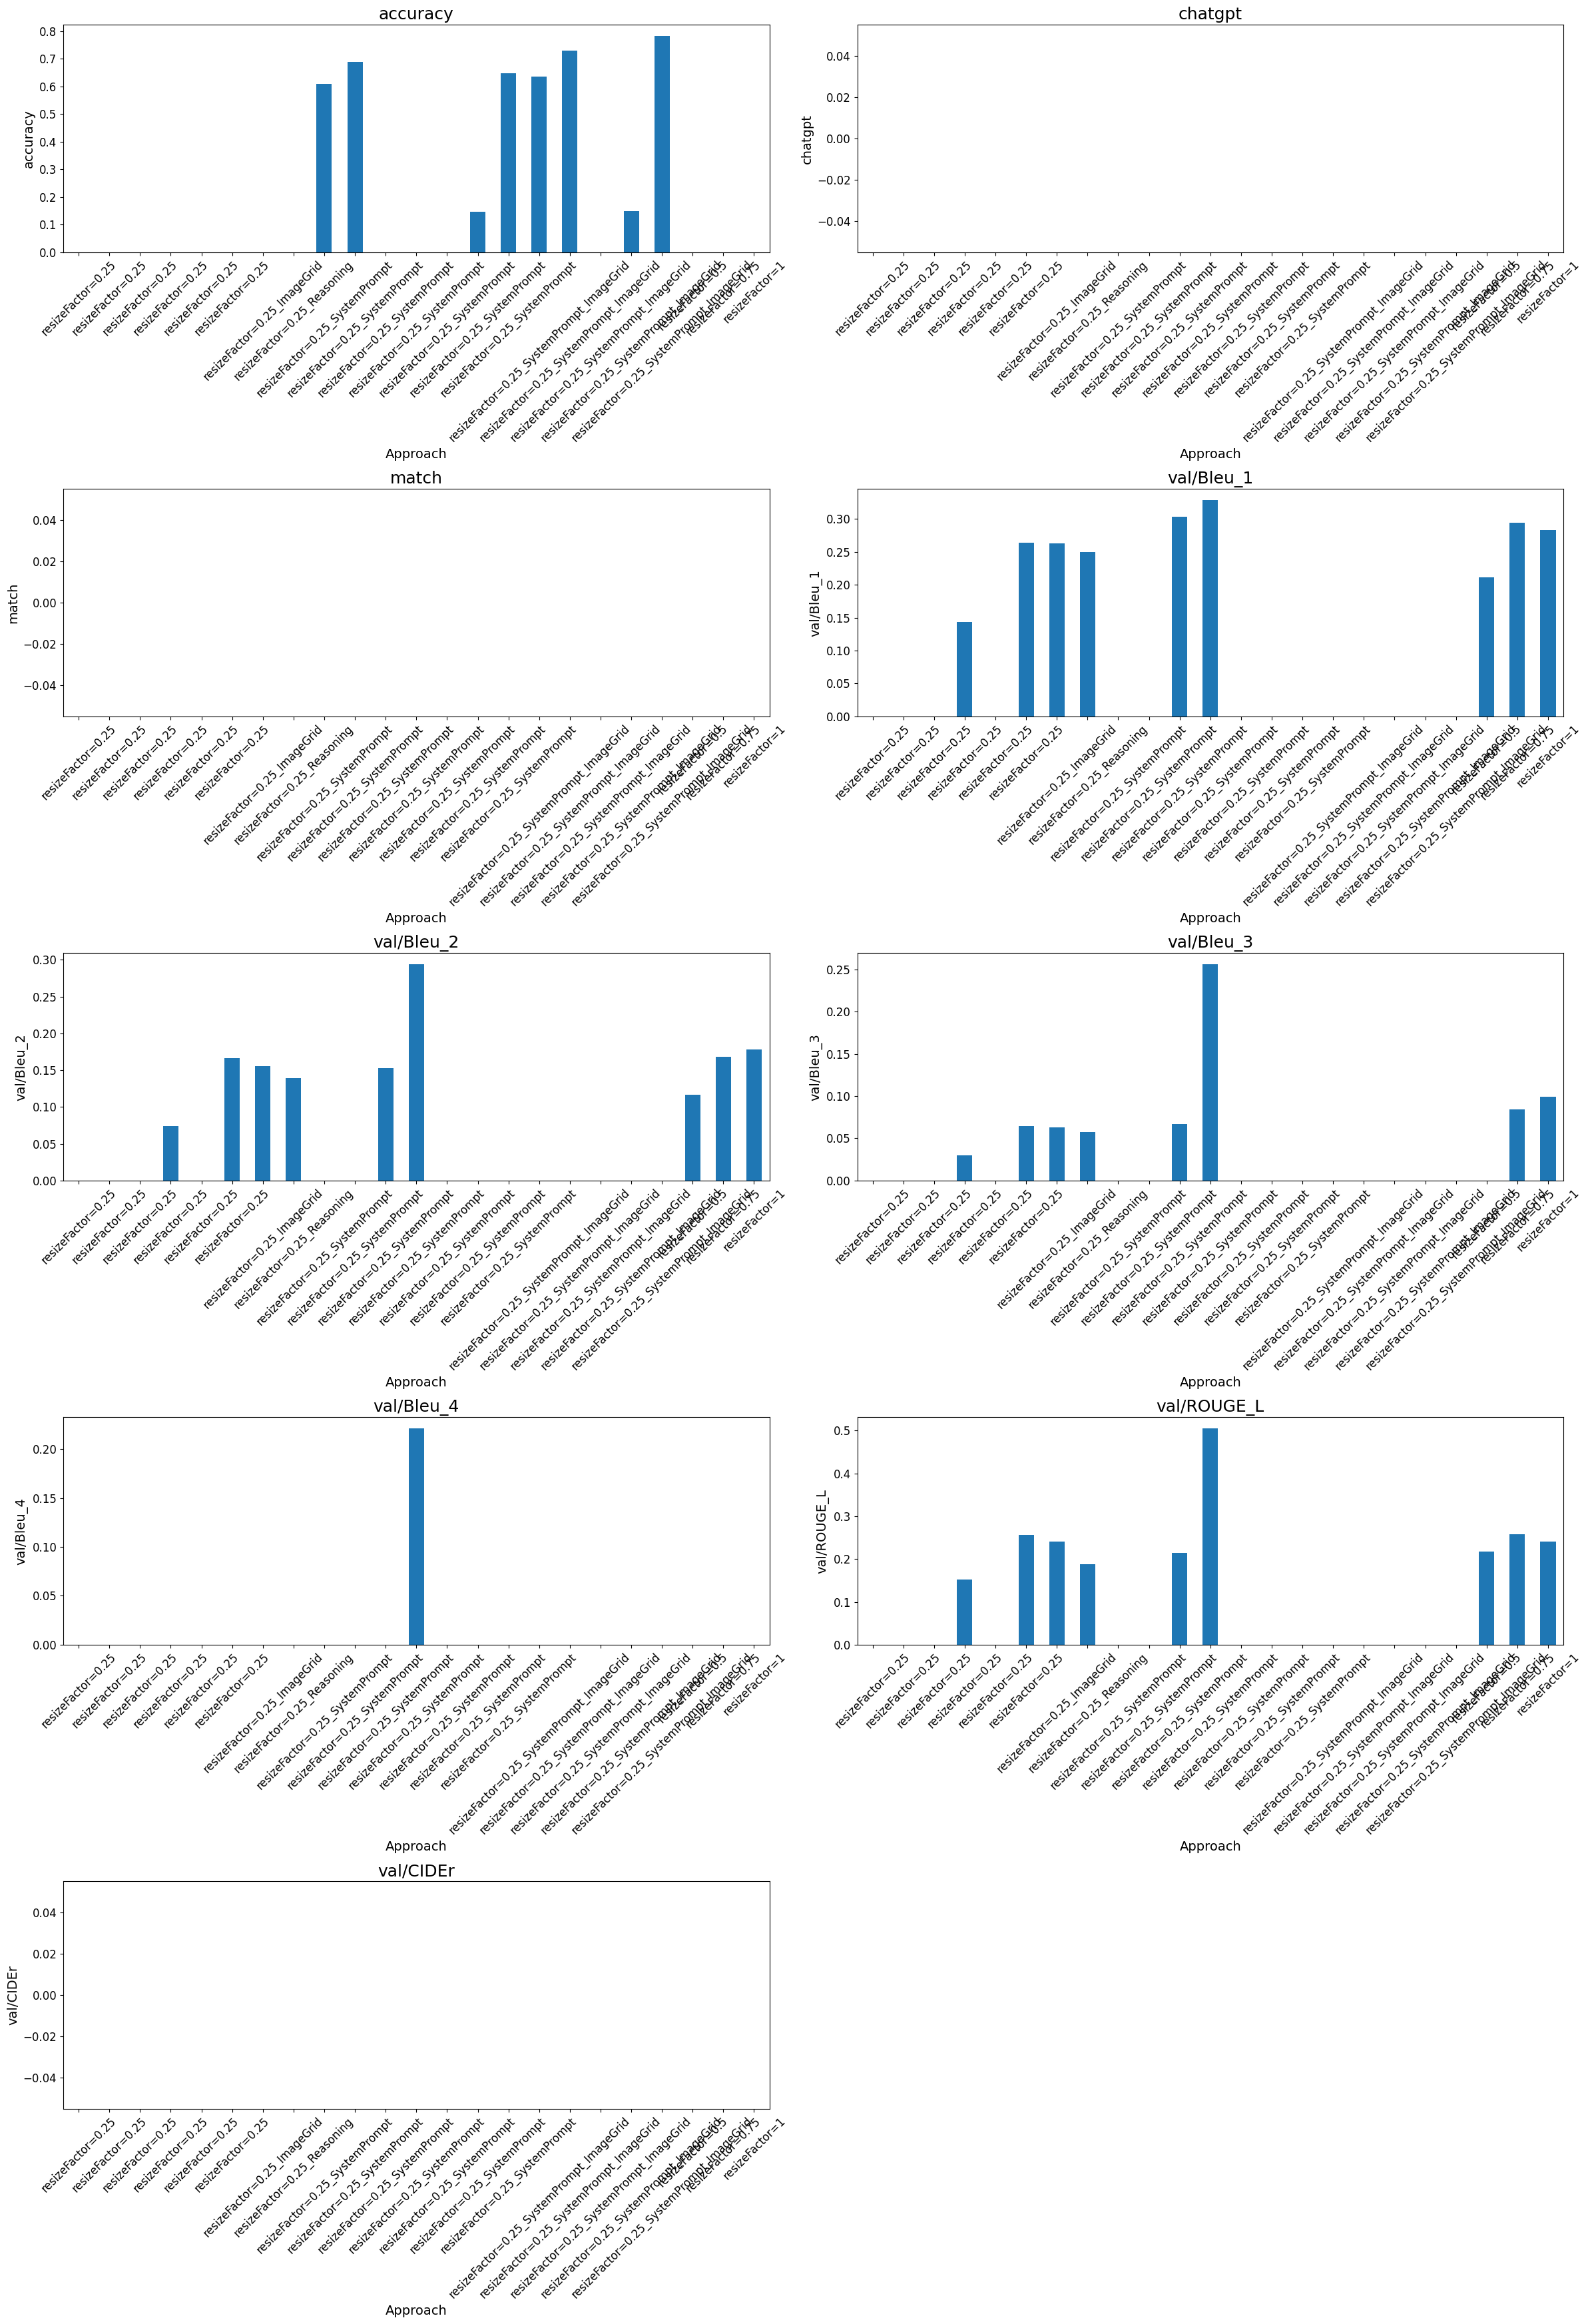

In [42]:
# Bar chats for score
n_cols = 2
n_rows = int(np.ceil(len(score_keys) / n_cols))
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(12 * n_cols, 7 * n_rows), sharey=False
)
axes = axes.flatten()  # Flatten in case of single row

for i, key in enumerate(score_keys):
    df.plot.bar(x="approach", y=key, ax=axes[i], legend=False)
    axes[i].set_title(key, fontsize=18)
    axes[i].set_xlabel("Approach", fontsize=14)
    axes[i].set_ylabel(key, fontsize=14)
    axes[i].tick_params(axis="x", rotation=45, labelsize=12)
    axes[i].tick_params(axis="y", labelsize=12)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [10]:
#  Per-Question Analysis

# 10 Best & 10 Worst Questions for Each Score and Approach
per_question_score_keys = [
    "accuracy",
    "match",
    "Bleu_1",
    "Bleu_2",
    "Bleu_3",
    "Bleu_4",
    "ROUGE_L",
    "CIDEr",
]

for idx, row in df.iterrows():
    approach = row["approach"]
    model = row["info"]

    file = [f for f in result_files if os.path.basename(f).startswith(approach)][0]
    with open(file, "r") as f:
        data = json.load(f)
    per_q = data.get("per_question_scores", {})
    print(f"\n=== Model: {model} | Approach: {approach} ===")
    for score in per_question_score_keys:
        q_scores = [
            (qid, v.get(score)) for qid, v in per_q.items() if v.get(score) is not None
        ]
        if not q_scores:
            continue

        q_scores_sorted = sorted(q_scores, key=lambda x: x[1])

        print(f"\nScore: {score}")
        print("10 Worst:")
        display(pd.DataFrame(q_scores_sorted[:10], columns=["question_id", score]))
        print("10 Best:")
        display(pd.DataFrame(q_scores_sorted[-10:], columns=["question_id", score]))

# Mean, standard deviation, median of each score by approach
std_median_rows = []
for idx, row in df.iterrows():
    approach = row["approach"]
    model = row["info"]
    file = [f for f in result_files if os.path.basename(f).startswith(approach)][0]
    with open(file, "r") as f:
        data = json.load(f)
    per_q = data.get("per_question_scores", {})
    stats = {"model": model, "approach": approach}
    for score in per_question_score_keys:
        vals = [v.get(score) for v in per_q.values() if v.get(score) is not None]
        if vals:
            stats[f"{score}_mean"] = np.mean(vals)
            stats[f"{score}_std"] = np.std(vals)
            stats[f"{score}_median"] = np.median(vals)
        else:
            stats[f"{score}_mean"] = np.nan
            stats[f"{score}_std"] = np.nan
            stats[f"{score}_median"] = np.nan
    std_median_rows.append(stats)

std_median_df = pd.DataFrame(std_median_rows)
print("Standard deviation and median")
display(std_median_df)


=== Model: Qwen_Qwen2.5-VL-3B-Instruct/test_3000 | Approach: resizeFactor=0.25 ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
3,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
7,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_b6bf5a2bcb094...,0.0


10 Best:


,question_id,accuracy
0,5aa5225d0ef440519a31c1dde075dab7_b7dca9f28e4d4...,1.0
1,5aa5225d0ef440519a31c1dde075dab7_d07cdad3cb0e4...,1.0
2,bc219c0fa63b43b4b9dddab47fce1fef_519b85741bad4...,1.0
3,bc219c0fa63b43b4b9dddab47fce1fef_dc6765726bb34...,1.0
4,268099669c954f429087081530094337_3f67b341fc414...,1.0
5,4a4d09496d594c7385a1ec227bdb3a7f_a2bbe30b96dd4...,1.0
6,48ba943c3d19463a81281bf6a7078eac_284670d3d1624...,1.0
7,d58468c6097c425e89671a7b3f480acf_5b8db833f04e4...,1.0
8,25f40f7316954a3e978e24d691e1a117_0f3efffcbbc64...,1.0
9,2ba06ef7b3b44cbfad6d771981d86af9_5f9d64f672fa4...,1.0



=== Model: Qwen_Qwen2.5-VL-3B-Instruct/test_3000 | Approach: resizeFactor=0.25_ImageGrid ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
2,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
3,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
5,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0
6,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,0.0
7,1977a1c98a6c4eb79fbc2a6dc0da9b0f_b6bf5a2bcb094...,0.0
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_0a208b6bd70a4...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.0


10 Best:


,question_id,accuracy
0,268099669c954f429087081530094337_3f67b341fc414...,1.0
1,4a4d09496d594c7385a1ec227bdb3a7f_a2bbe30b96dd4...,1.0
2,d58468c6097c425e89671a7b3f480acf_5b8db833f04e4...,1.0
3,25f40f7316954a3e978e24d691e1a117_0f3efffcbbc64...,1.0
4,25f40f7316954a3e978e24d691e1a117_1bc3350f92764...,1.0
5,2ba06ef7b3b44cbfad6d771981d86af9_9d14bc2a71744...,1.0
6,2ba06ef7b3b44cbfad6d771981d86af9_5f9d64f672fa4...,1.0
7,2ba06ef7b3b44cbfad6d771981d86af9_a9f7830efde24...,1.0
8,2ba06ef7b3b44cbfad6d771981d86af9_3560d394a3e44...,1.0
9,2ba06ef7b3b44cbfad6d771981d86af9_b1d5f0b98bdf4...,1.0



=== Model: Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/behavior | Approach: resizeFactor=0.25_ImageGrid_prompt ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
2,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
3,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
5,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0
6,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,0.0
7,1977a1c98a6c4eb79fbc2a6dc0da9b0f_b6bf5a2bcb094...,0.0
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_0a208b6bd70a4...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.0


10 Best:


,question_id,accuracy
0,268099669c954f429087081530094337_3f67b341fc414...,1.0
1,4a4d09496d594c7385a1ec227bdb3a7f_a2bbe30b96dd4...,1.0
2,d58468c6097c425e89671a7b3f480acf_5b8db833f04e4...,1.0
3,25f40f7316954a3e978e24d691e1a117_0f3efffcbbc64...,1.0
4,25f40f7316954a3e978e24d691e1a117_1bc3350f92764...,1.0
5,2ba06ef7b3b44cbfad6d771981d86af9_9d14bc2a71744...,1.0
6,2ba06ef7b3b44cbfad6d771981d86af9_5f9d64f672fa4...,1.0
7,2ba06ef7b3b44cbfad6d771981d86af9_a9f7830efde24...,1.0
8,2ba06ef7b3b44cbfad6d771981d86af9_3560d394a3e44...,1.0
9,2ba06ef7b3b44cbfad6d771981d86af9_b1d5f0b98bdf4...,1.0



=== Model: Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/yes_no/test_500 | Approach: resizeFactor=0.25_ImageGrid_prompt ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
2,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
3,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
5,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0
6,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,0.0
7,1977a1c98a6c4eb79fbc2a6dc0da9b0f_b6bf5a2bcb094...,0.0
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_0a208b6bd70a4...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.0


10 Best:


,question_id,accuracy
0,268099669c954f429087081530094337_3f67b341fc414...,1.0
1,4a4d09496d594c7385a1ec227bdb3a7f_a2bbe30b96dd4...,1.0
2,d58468c6097c425e89671a7b3f480acf_5b8db833f04e4...,1.0
3,25f40f7316954a3e978e24d691e1a117_0f3efffcbbc64...,1.0
4,25f40f7316954a3e978e24d691e1a117_1bc3350f92764...,1.0
5,2ba06ef7b3b44cbfad6d771981d86af9_9d14bc2a71744...,1.0
6,2ba06ef7b3b44cbfad6d771981d86af9_5f9d64f672fa4...,1.0
7,2ba06ef7b3b44cbfad6d771981d86af9_a9f7830efde24...,1.0
8,2ba06ef7b3b44cbfad6d771981d86af9_3560d394a3e44...,1.0
9,2ba06ef7b3b44cbfad6d771981d86af9_b1d5f0b98bdf4...,1.0



=== Model: Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/yes_no/test_50 | Approach: resizeFactor=0.25_ImageGrid_prompt ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
2,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
3,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
5,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0
6,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,0.0
7,1977a1c98a6c4eb79fbc2a6dc0da9b0f_b6bf5a2bcb094...,0.0
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_0a208b6bd70a4...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.0


10 Best:


,question_id,accuracy
0,268099669c954f429087081530094337_3f67b341fc414...,1.0
1,4a4d09496d594c7385a1ec227bdb3a7f_a2bbe30b96dd4...,1.0
2,d58468c6097c425e89671a7b3f480acf_5b8db833f04e4...,1.0
3,25f40f7316954a3e978e24d691e1a117_0f3efffcbbc64...,1.0
4,25f40f7316954a3e978e24d691e1a117_1bc3350f92764...,1.0
5,2ba06ef7b3b44cbfad6d771981d86af9_9d14bc2a71744...,1.0
6,2ba06ef7b3b44cbfad6d771981d86af9_5f9d64f672fa4...,1.0
7,2ba06ef7b3b44cbfad6d771981d86af9_a9f7830efde24...,1.0
8,2ba06ef7b3b44cbfad6d771981d86af9_3560d394a3e44...,1.0
9,2ba06ef7b3b44cbfad6d771981d86af9_b1d5f0b98bdf4...,1.0



=== Model: Qwen_Qwen2.5-VL-3B-Instruct/test_3000 | Approach: resizeFactor=0.25_Reasoning ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,accuracy
0,9e7d5adad1514dd79292e9318b7a443c_8e4c9979be3a4...,0.0
1,cd1a8954ff904333bb13fa1a6ee526fd_a107b3f5e9544...,0.0
2,cd1a8954ff904333bb13fa1a6ee526fd_5bf2c08a42994...,0.0
3,cd1a8954ff904333bb13fa1a6ee526fd_33d3ace0ff7b4...,0.0
4,cd1a8954ff904333bb13fa1a6ee526fd_9c8e4c574a1b4...,0.0
5,cd1a8954ff904333bb13fa1a6ee526fd_3103867330464...,0.0
6,9056ac9944e846109b00e31cc96259cb_744b7aa2a40f4...,0.0
7,9056ac9944e846109b00e31cc96259cb_7fc1d2f92f184...,0.0
8,9056ac9944e846109b00e31cc96259cb_51e71d7f15d54...,0.0
9,9056ac9944e846109b00e31cc96259cb_124db1e887a94...,0.0



Score: match
10 Worst:


,question_id,match
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.0
5,ba76f4185aa34ed3bff467ac640da902_019813f350c74...,0.0
6,ba76f4185aa34ed3bff467ac640da902_d0c8108acf3a4...,0.0
7,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,0.0
8,76c632788f8c4516bef1c4297f2002f6_e50b488783c64...,0.0
9,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,0.0


10 Best:


,question_id,match
0,875e9b8b63b54263ba1edeb21faadea8_7460187a16894...,0.0
1,875e9b8b63b54263ba1edeb21faadea8_f7e9924344194...,0.0
2,e3094e1174654d119b55cce4df145e02_71ae08d35ef64...,0.0
3,e3094e1174654d119b55cce4df145e02_46cf34e67e3c4...,0.0
4,e3094e1174654d119b55cce4df145e02_c8170f1633034...,0.0
5,e3094e1174654d119b55cce4df145e02_551f81ab0bf64...,0.0
6,e3094e1174654d119b55cce4df145e02_fb35caa6f9944...,0.0
7,19284973bd0342998c37848e931a90d0_69cd43d86ab04...,0.0
8,19284973bd0342998c37848e931a90d0_66af1b4849b24...,0.0
9,19284973bd0342998c37848e931a90d0_17a97d5cbae34...,0.0



Score: Bleu_1
10 Worst:


,question_id,Bleu_1
0,0c601ff2bf004fccafec366b08bf29e2_15ab387215034...,0.069737
1,0c601ff2bf004fccafec366b08bf29e2_17a0068044014...,0.080947
2,bfe368f8c6a44efcb323a82f6974a9a6_8937b75340024...,0.086613
3,692fe09aecae4b1a94f8a3bceedd9b7c_38c4644a31bf4...,0.094018
4,5890face846e47a899246159b7c30bd7_df256f506fc74...,0.109091
5,e329b73341204af7a9de29e65291ce1c_44eb0257e2c84...,0.110000
6,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,0.111111
7,53e8446852bf488bb1b09ae032918bbd_c81b9f7068244...,0.111111
8,9056ac9944e846109b00e31cc96259cb_124db1e887a94...,0.112150
9,23e33c8bba1f411ba5871dc074f8dbf8_6100862b51064...,0.113208


10 Best:


,question_id,Bleu_1
0,27dc2edfb6524c7d8997ac3573ed2f3d_71478e1cd4574...,0.297948
1,74d03e3b673f4a72a3f76e1b0c7840bd_e90d170e63a24...,0.298063
2,35ecd252b8ee4cbc83376148e192a803_0fb5cb79f68e4...,0.299792
3,e0b14a8e11994763acba690bbcc3f56a_0e364b7146c84...,0.303180
4,15e1fa06e30e438a98430cc1fd0e8a69_fff90cea23294...,0.307018
5,1d25e9071ea94891b5eb7554e77a11bb_3b4d84b7f0114...,0.311927
6,25f40f7316954a3e978e24d691e1a117_0f3efffcbbc64...,0.317397
7,4f28b42169f4404cbab4b43476e13885_6da82e1adba04...,0.321101
8,fee7ac5f5c1e4943877cd20d6e069427_7aa11dc80ec24...,0.323928
9,15e1fa06e30e438a98430cc1fd0e8a69_ff39a0c1ceb64...,0.332779



Score: Bleu_2
10 Worst:


,question_id,Bleu_2
0,45fc8a7a26c5469a88db999ae8468777_23fa9a7b75f04...,1.060640e-09
1,4a4d09496d594c7385a1ec227bdb3a7f_a4bfa219eb014...,1.198981e-09
2,7bbc6931b39b4ba3834240618fc4a4c2_6ee319f6be084...,1.214167e-09
3,bc219c0fa63b43b4b9dddab47fce1fef_519b85741bad4...,1.236250e-09
4,fee7ac5f5c1e4943877cd20d6e069427_60ae5aad45434...,1.367056e-09
5,5890face846e47a899246159b7c30bd7_df256f506fc74...,3.163596e-02
6,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,3.222455e-02
7,53e8446852bf488bb1b09ae032918bbd_c81b9f7068244...,3.222455e-02
8,4f28b42169f4404cbab4b43476e13885_ebfa67afc5f64...,3.233711e-02
9,73b16c26a0d24c7a841e4cbe5d0d7878_0630fbd880224...,3.262976e-02


10 Best:


,question_id,Bleu_2
0,2ba06ef7b3b44cbfad6d771981d86af9_6862a5e0b4bd4...,0.167170
1,82240fd6d5ba4375815f8a7fa1561361_b35b02f7296b4...,0.167350
2,74d03e3b673f4a72a3f76e1b0c7840bd_e90d170e63a24...,0.170116
3,fee7ac5f5c1e4943877cd20d6e069427_7aa11dc80ec24...,0.172609
4,25f40f7316954a3e978e24d691e1a117_0f3efffcbbc64...,0.174035
5,5aa5225d0ef440519a31c1dde075dab7_b7dca9f28e4d4...,0.175750
6,e1e664292aa144bc8d0d5d6441df084c_5745949130934...,0.189733
7,15e1fa06e30e438a98430cc1fd0e8a69_ff39a0c1ceb64...,0.193079
8,1d25e9071ea94891b5eb7554e77a11bb_3b4d84b7f0114...,0.193770
9,4f28b42169f4404cbab4b43476e13885_6da82e1adba04...,0.196599



Score: Bleu_3
10 Worst:


,question_id,Bleu_3
0,45fc8a7a26c5469a88db999ae8468777_23fa9a7b75f04...,2.197573e-12
1,7bbc6931b39b4ba3834240618fc4a4c2_6ee319f6be084...,2.382558e-12
2,4a4d09496d594c7385a1ec227bdb3a7f_a4bfa219eb014...,2.399922e-12
3,bc219c0fa63b43b4b9dddab47fce1fef_519b85741bad4...,2.404030e-12
4,fee7ac5f5c1e4943877cd20d6e069427_60ae5aad45434...,2.594555e-12
5,5890face846e47a899246159b7c30bd7_df256f506fc74...,2.100452e-07
6,4f28b42169f4404cbab4b43476e13885_ebfa67afc5f64...,2.118377e-07
7,73b16c26a0d24c7a841e4cbe5d0d7878_0630fbd880224...,2.137636e-07
8,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,2.139715e-07
9,53e8446852bf488bb1b09ae032918bbd_c81b9f7068244...,2.139715e-07


10 Best:


,question_id,Bleu_3
0,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.087481
1,1d25e9071ea94891b5eb7554e77a11bb_3b4d84b7f0114...,0.088867
2,15e1fa06e30e438a98430cc1fd0e8a69_ff39a0c1ceb64...,0.088917
3,48ba943c3d19463a81281bf6a7078eac_284670d3d1624...,0.088929
4,268099669c954f429087081530094337_e0c123373fe74...,0.089683
5,1c76efe7d0b048bc815c0445eeaa76ab_8ae837b713ca4...,0.089856
6,fee7ac5f5c1e4943877cd20d6e069427_7aa11dc80ec24...,0.092605
7,5aa5225d0ef440519a31c1dde075dab7_b7dca9f28e4d4...,0.094444
8,e1e664292aa144bc8d0d5d6441df084c_5745949130934...,0.100624
9,4f28b42169f4404cbab4b43476e13885_6da82e1adba04...,0.102715



Score: Bleu_4
10 Worst:


,question_id,Bleu_4
0,45fc8a7a26c5469a88db999ae8468777_23fa9a7b75f04...,1.002675e-13
1,7bbc6931b39b4ba3834240618fc4a4c2_6ee319f6be084...,1.057856e-13
2,bc219c0fa63b43b4b9dddab47fce1fef_519b85741bad4...,1.062548e-13
3,4a4d09496d594c7385a1ec227bdb3a7f_a4bfa219eb014...,1.076313e-13
4,fee7ac5f5c1e4943877cd20d6e069427_60ae5aad45434...,1.132976e-13
5,5890face846e47a899246159b7c30bd7_df256f506fc74...,5.424861e-10
6,4f28b42169f4404cbab4b43476e13885_ebfa67afc5f64...,5.434327e-10
7,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,5.435482e-10
8,73b16c26a0d24c7a841e4cbe5d0d7878_0630fbd880224...,5.483961e-10
9,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,5.526748e-10


10 Best:


,question_id,Bleu_4
0,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.049972
1,a99120daccb24bcd941b33e6e03bf718_cb19f2c084fa4...,0.051393
2,44f25e0b668e4077abf57f3df320bb57_573e53458b654...,0.052011
3,5aa5225d0ef440519a31c1dde075dab7_b7dca9f28e4d4...,0.052726
4,eac3102e4cc24d4b95532bcc711a902f_7f703ec9c5c64...,0.052789
5,81227a12571240e0b9d537165f57e177_084ba4c160054...,0.054451
6,4f28b42169f4404cbab4b43476e13885_6da82e1adba04...,0.056546
7,1c76efe7d0b048bc815c0445eeaa76ab_8ae837b713ca4...,0.061116
8,97ba0e14805b42f292db7f06b6d1121b_553cf979a6784...,0.062879
9,48ba943c3d19463a81281bf6a7078eac_284670d3d1624...,0.066483



Score: ROUGE_L
10 Worst:


,question_id,ROUGE_L
0,5b9c64f03f8b4a4f8189a18d74f866c2_4ffa9f7e6ba54...,0.076617
1,7f03cd19d9cc4381a591fca00666d7ed_dbf0c9299b164...,0.081769
2,7f03cd19d9cc4381a591fca00666d7ed_96ad2e2529004...,0.084766
3,b829278aae2747959f2a95423455bbcb_18827f57c05c4...,0.085050
4,53e8446852bf488bb1b09ae032918bbd_c81b9f7068244...,0.085196
5,23e33c8bba1f411ba5871dc074f8dbf8_6100862b51064...,0.085381
6,7540f31d12f1439db67a50be7726c70d_d498c008b00b4...,0.090939
7,453453c849304ad69741891946d46453_3d4b18f370274...,0.093101
8,23e33c8bba1f411ba5871dc074f8dbf8_d283a15250234...,0.093415
9,5890face846e47a899246159b7c30bd7_df256f506fc74...,0.093415


10 Best:


,question_id,ROUGE_L
0,eac3102e4cc24d4b95532bcc711a902f_7f703ec9c5c64...,0.241207
1,796e7ae080984a0ab2b96ce80f18ca3b_1660f97c9c674...,0.242545
2,212b65c558254e2084489bf76e371e1a_93143577a4084...,0.242773
3,fdf4384c1fce4a16aad939d8417bccd6_67947eae929a4...,0.244051
4,4f28b42169f4404cbab4b43476e13885_6da82e1adba04...,0.246922
5,5aa5225d0ef440519a31c1dde075dab7_b7dca9f28e4d4...,0.253073
6,97ba0e14805b42f292db7f06b6d1121b_84d48a54bbf44...,0.254000
7,c6072dd4f7cc47efaad77889aa465ad6_472419e637b84...,0.262636
8,e0b14a8e11994763acba690bbcc3f56a_0e364b7146c84...,0.272592
9,25f40f7316954a3e978e24d691e1a117_0f3efffcbbc64...,0.299215



Score: CIDEr
10 Worst:


,question_id,CIDEr
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,CIDEr
0,9e7d5adad1514dd79292e9318b7a443c_8e4c9979be3a4...,0.0
1,cd1a8954ff904333bb13fa1a6ee526fd_a107b3f5e9544...,0.0
2,cd1a8954ff904333bb13fa1a6ee526fd_5bf2c08a42994...,0.0
3,cd1a8954ff904333bb13fa1a6ee526fd_33d3ace0ff7b4...,0.0
4,cd1a8954ff904333bb13fa1a6ee526fd_9c8e4c574a1b4...,0.0
5,cd1a8954ff904333bb13fa1a6ee526fd_3103867330464...,0.0
6,9056ac9944e846109b00e31cc96259cb_744b7aa2a40f4...,0.0
7,9056ac9944e846109b00e31cc96259cb_7fc1d2f92f184...,0.0
8,9056ac9944e846109b00e31cc96259cb_51e71d7f15d54...,0.0
9,9056ac9944e846109b00e31cc96259cb_124db1e887a94...,0.0



=== Model: Qwen_Qwen2.5-VL-3B-Instruct/test_3000 | Approach: resizeFactor=0.25_SystemPrompt ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,accuracy
0,9e7d5adad1514dd79292e9318b7a443c_8e4c9979be3a4...,0.0
1,cd1a8954ff904333bb13fa1a6ee526fd_a107b3f5e9544...,0.0
2,cd1a8954ff904333bb13fa1a6ee526fd_5bf2c08a42994...,0.0
3,cd1a8954ff904333bb13fa1a6ee526fd_33d3ace0ff7b4...,0.0
4,cd1a8954ff904333bb13fa1a6ee526fd_9c8e4c574a1b4...,0.0
5,cd1a8954ff904333bb13fa1a6ee526fd_3103867330464...,0.0
6,9056ac9944e846109b00e31cc96259cb_744b7aa2a40f4...,0.0
7,9056ac9944e846109b00e31cc96259cb_7fc1d2f92f184...,0.0
8,9056ac9944e846109b00e31cc96259cb_51e71d7f15d54...,0.0
9,9056ac9944e846109b00e31cc96259cb_124db1e887a94...,0.0



Score: match
10 Worst:


,question_id,match
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.0
5,ba76f4185aa34ed3bff467ac640da902_019813f350c74...,0.0
6,ba76f4185aa34ed3bff467ac640da902_d0c8108acf3a4...,0.0
7,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,0.0
8,76c632788f8c4516bef1c4297f2002f6_e50b488783c64...,0.0
9,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,0.0


10 Best:


,question_id,match
0,875e9b8b63b54263ba1edeb21faadea8_7460187a16894...,0.0
1,875e9b8b63b54263ba1edeb21faadea8_f7e9924344194...,0.0
2,e3094e1174654d119b55cce4df145e02_71ae08d35ef64...,0.0
3,e3094e1174654d119b55cce4df145e02_46cf34e67e3c4...,0.0
4,e3094e1174654d119b55cce4df145e02_c8170f1633034...,0.0
5,e3094e1174654d119b55cce4df145e02_551f81ab0bf64...,0.0
6,e3094e1174654d119b55cce4df145e02_fb35caa6f9944...,0.0
7,19284973bd0342998c37848e931a90d0_69cd43d86ab04...,0.0
8,19284973bd0342998c37848e931a90d0_66af1b4849b24...,0.0
9,19284973bd0342998c37848e931a90d0_17a97d5cbae34...,0.0



Score: Bleu_1
10 Worst:


,question_id,Bleu_1
0,5c9bd7ead37e4aa9989f7909f3a78baa_57c9e0442de24...,0.000405
1,af128e79b77a4a4b8bfcd997c320b2a9_73376e2fc5d34...,0.002146
2,0c601ff2bf004fccafec366b08bf29e2_15ab387215034...,0.009556
3,fdf27bbde3e345bd9ac83cbe9a3c813a_b3b29fa2928c4...,0.010643
4,3032b651c72e4b5c86d4dea1b4930689_6083a55b86354...,0.021051
5,567fcd99d0dc4fa088f52b047f4ebdcf_e080aab620344...,0.055008
6,cf550d9670274ac1a7f274fbacb39c48_0d50b5bbfe744...,0.061981
7,0c601ff2bf004fccafec366b08bf29e2_5a1f37aea5be4...,0.068376
8,0c601ff2bf004fccafec366b08bf29e2_b954b1f2ddba4...,0.081009
9,25f40f7316954a3e978e24d691e1a117_5530fc2a67434...,0.095238


10 Best:


,question_id,Bleu_1
0,a99120daccb24bcd941b33e6e03bf718_33d1c7fcf9744...,0.340426
1,a99120daccb24bcd941b33e6e03bf718_b6fb8b0f247f4...,0.345429
2,8b43539a55374b6c8ed60c95a42d63a2_7c3d257872084...,0.345429
3,2ba06ef7b3b44cbfad6d771981d86af9_a9f7830efde24...,0.345441
4,692fe09aecae4b1a94f8a3bceedd9b7c_38c4644a31bf4...,0.346137
5,47a73fb6a41a4c4b9fe2897254dd3671_417f71c9fc014...,0.347805
6,dd61533869aa48f2aaa7e8a6418bdbe6_65b7811ca02e4...,0.348485
7,c6072dd4f7cc47efaad77889aa465ad6_2426422ecc564...,0.350877
8,c2d5a5e7f7dc4e12b967fff22a0e1bf1_fdebfd74db044...,0.356522
9,53c92676ef334011bd4689494ac11fa0_971f7df7e4f64...,0.396825



Score: Bleu_2
10 Worst:


,question_id,Bleu_2
0,5c9bd7ead37e4aa9989f7909f3a78baa_57c9e0442de24...,6.796767e-12
1,af128e79b77a4a4b8bfcd997c320b2a9_73376e2fc5d34...,3.598541e-11
2,cf550d9670274ac1a7f274fbacb39c48_0d50b5bbfe744...,6.285980e-10
3,567fcd99d0dc4fa088f52b047f4ebdcf_6701ecd1c9ca4...,1.013499e-09
4,cab845a2e8864482993ac62811f879c1_37938fd79ce14...,1.128809e-09
5,1891b66d9f58463399aa242f3b521232_90db859e92494...,1.150008e-09
6,48ba943c3d19463a81281bf6a7078eac_c02035b28c114...,1.150008e-09
7,2422d2652f4f42298a389a6e0dfef307_7e675d1e19b84...,1.169211e-09
8,c77e6ecf108c4c8b80d35d84642c805f_f9d99bd0ad1d4...,1.247438e-09
9,0c601ff2bf004fccafec366b08bf29e2_15ab387215034...,5.641147e-03


10 Best:


,question_id,Bleu_2
0,16c90eedfc7943a5a4c64e84d18876a2_dc997a6f3d374...,0.216012
1,692fe09aecae4b1a94f8a3bceedd9b7c_38c4644a31bf4...,0.216193
2,a99120daccb24bcd941b33e6e03bf718_33d1c7fcf9744...,0.218143
3,cd1a8954ff904333bb13fa1a6ee526fd_3103867330464...,0.218218
4,47a73fb6a41a4c4b9fe2897254dd3671_417f71c9fc014...,0.222911
5,66134aebdaca4aca82aec91ec8c6245e_ef984c99cb3e4...,0.223439
6,dd61533869aa48f2aaa7e8a6418bdbe6_65b7811ca02e4...,0.253645
7,c2d5a5e7f7dc4e12b967fff22a0e1bf1_fdebfd74db044...,0.256271
8,8b43539a55374b6c8ed60c95a42d63a2_7c3d257872084...,0.270399
9,53c92676ef334011bd4689494ac11fa0_971f7df7e4f64...,0.309849



Score: Bleu_3
10 Worst:


,question_id,Bleu_3
0,5c9bd7ead37e4aa9989f7909f3a78baa_57c9e0442de24...,1.818926e-14
1,af128e79b77a4a4b8bfcd997c320b2a9_73376e2fc5d34...,9.630287e-14
2,cf550d9670274ac1a7f274fbacb39c48_0d50b5bbfe744...,1.373858e-12
3,567fcd99d0dc4fa088f52b047f4ebdcf_6701ecd1c9ca4...,2.099462e-12
4,cab845a2e8864482993ac62811f879c1_37938fd79ce14...,2.283595e-12
5,1891b66d9f58463399aa242f3b521232_90db859e92494...,2.326684e-12
6,48ba943c3d19463a81281bf6a7078eac_c02035b28c114...,2.326684e-12
7,c77e6ecf108c4c8b80d35d84642c805f_f9d99bd0ad1d4...,2.425887e-12
8,2422d2652f4f42298a389a6e0dfef307_7e675d1e19b84...,2.631731e-12
9,0c601ff2bf004fccafec366b08bf29e2_b954b1f2ddba4...,1.491556e-07


10 Best:


,question_id,Bleu_3
0,47a73fb6a41a4c4b9fe2897254dd3671_417f71c9fc014...,0.140289
1,af128e79b77a4a4b8bfcd997c320b2a9_f894634842c34...,0.144621
2,a99120daccb24bcd941b33e6e03bf718_33d1c7fcf9744...,0.145864
3,66134aebdaca4aca82aec91ec8c6245e_ef984c99cb3e4...,0.151880
4,2422d2652f4f42298a389a6e0dfef307_f765c2cac3004...,0.158449
5,dd61533869aa48f2aaa7e8a6418bdbe6_65b7811ca02e4...,0.159017
6,7bbc6931b39b4ba3834240618fc4a4c2_e355b1f974144...,0.162900
7,c2d5a5e7f7dc4e12b967fff22a0e1bf1_fdebfd74db044...,0.191059
8,8b43539a55374b6c8ed60c95a42d63a2_7c3d257872084...,0.219266
9,53c92676ef334011bd4689494ac11fa0_971f7df7e4f64...,0.241956



Score: Bleu_4
10 Worst:


,question_id,Bleu_4
0,5c9bd7ead37e4aa9989f7909f3a78baa_57c9e0442de24...,9.779309e-16
1,af128e79b77a4a4b8bfcd997c320b2a9_73376e2fc5d34...,5.177646e-15
2,cf550d9670274ac1a7f274fbacb39c48_0d50b5bbfe744...,6.470941e-14
3,567fcd99d0dc4fa088f52b047f4ebdcf_6701ecd1c9ca4...,9.577073e-14
4,cab845a2e8864482993ac62811f879c1_37938fd79ce14...,1.029527e-13
5,1891b66d9f58463399aa242f3b521232_90db859e92494...,1.049047e-13
6,48ba943c3d19463a81281bf6a7078eac_c02035b28c114...,1.049047e-13
7,c77e6ecf108c4c8b80d35d84642c805f_f9d99bd0ad1d4...,1.072252e-13
8,2422d2652f4f42298a389a6e0dfef307_7e675d1e19b84...,1.252775e-13
9,0c601ff2bf004fccafec366b08bf29e2_b954b1f2ddba4...,3.843688e-10


10 Best:


,question_id,Bleu_4
0,2422d2652f4f42298a389a6e0dfef307_3ea38d2fcb324...,0.098566
1,82240fd6d5ba4375815f8a7fa1561361_f942612a2e2f4...,0.099494
2,3032b651c72e4b5c86d4dea1b4930689_516d9678d6bf4...,0.100268
3,dc6235e2281943548084c484cb38b876_78e7729b8de44...,0.112264
4,2422d2652f4f42298a389a6e0dfef307_f765c2cac3004...,0.121646
5,af128e79b77a4a4b8bfcd997c320b2a9_f894634842c34...,0.121786
6,7bbc6931b39b4ba3834240618fc4a4c2_e355b1f974144...,0.122085
7,c2d5a5e7f7dc4e12b967fff22a0e1bf1_fdebfd74db044...,0.125628
8,8b43539a55374b6c8ed60c95a42d63a2_7c3d257872084...,0.176527
9,53c92676ef334011bd4689494ac11fa0_971f7df7e4f64...,0.194001



Score: ROUGE_L
10 Worst:


,question_id,ROUGE_L
0,5c9bd7ead37e4aa9989f7909f3a78baa_57c9e0442de24...,0.043308
1,af128e79b77a4a4b8bfcd997c320b2a9_73376e2fc5d34...,0.053579
2,2422d2652f4f42298a389a6e0dfef307_7e675d1e19b84...,0.054018
3,567fcd99d0dc4fa088f52b047f4ebdcf_e080aab620344...,0.068405
4,1891b66d9f58463399aa242f3b521232_90db859e92494...,0.085092
5,d58468c6097c425e89671a7b3f480acf_84ca8a70720b4...,0.096383
6,c77e6ecf108c4c8b80d35d84642c805f_05c7951d982f4...,0.097669
7,25f40f7316954a3e978e24d691e1a117_5530fc2a67434...,0.098569
8,cf550d9670274ac1a7f274fbacb39c48_0d50b5bbfe744...,0.103140
9,48ba943c3d19463a81281bf6a7078eac_c02035b28c114...,0.104398


10 Best:


,question_id,ROUGE_L
0,fe4fdd7a28754baeac7074ad78f55a52_b4a6de0585664...,0.308185
1,3032b651c72e4b5c86d4dea1b4930689_6e349f86e1cc4...,0.308327
2,7bbc6931b39b4ba3834240618fc4a4c2_dac7e184acc84...,0.309713
3,cf652a711c8e40209132036a95162fed_33918843c2314...,0.311643
4,692fe09aecae4b1a94f8a3bceedd9b7c_38c4644a31bf4...,0.313520
5,c2d5a5e7f7dc4e12b967fff22a0e1bf1_fdebfd74db044...,0.314491
6,01796494e25c448dadaba70cfcc3532d_db23ac925c264...,0.323894
7,7bbc6931b39b4ba3834240618fc4a4c2_e355b1f974144...,0.327847
8,8b43539a55374b6c8ed60c95a42d63a2_7c3d257872084...,0.337638
9,53c92676ef334011bd4689494ac11fa0_971f7df7e4f64...,0.353184



Score: CIDEr
10 Worst:


,question_id,CIDEr
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,CIDEr
0,9e7d5adad1514dd79292e9318b7a443c_8e4c9979be3a4...,0.0
1,cd1a8954ff904333bb13fa1a6ee526fd_a107b3f5e9544...,0.0
2,cd1a8954ff904333bb13fa1a6ee526fd_5bf2c08a42994...,0.0
3,cd1a8954ff904333bb13fa1a6ee526fd_33d3ace0ff7b4...,0.0
4,cd1a8954ff904333bb13fa1a6ee526fd_9c8e4c574a1b4...,0.0
5,cd1a8954ff904333bb13fa1a6ee526fd_3103867330464...,0.0
6,9056ac9944e846109b00e31cc96259cb_744b7aa2a40f4...,0.0
7,9056ac9944e846109b00e31cc96259cb_7fc1d2f92f184...,0.0
8,9056ac9944e846109b00e31cc96259cb_51e71d7f15d54...,0.0
9,9056ac9944e846109b00e31cc96259cb_124db1e887a94...,0.0



=== Model: Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/behavior | Approach: resizeFactor=0.25_noPrompt ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,accuracy
0,aad7d3bf3c7a47ad9cb93d9b92ed38ee_a0ba38bcbffd4...,0.0
1,aad7d3bf3c7a47ad9cb93d9b92ed38ee_0739f0758a8e4...,0.0
2,74d03e3b673f4a72a3f76e1b0c7840bd_5b0fbfac8e734...,0.0
3,74d03e3b673f4a72a3f76e1b0c7840bd_6968e6f5253e4...,0.0
4,74d03e3b673f4a72a3f76e1b0c7840bd_e90d170e63a24...,0.0
5,74d03e3b673f4a72a3f76e1b0c7840bd_b8973db97ac94...,0.0
6,74d03e3b673f4a72a3f76e1b0c7840bd_56d369d0efeb4...,0.0
7,74d03e3b673f4a72a3f76e1b0c7840bd_21861bdc16594...,0.0
8,74d03e3b673f4a72a3f76e1b0c7840bd_6e54dfd8cdf34...,0.0
9,74d03e3b673f4a72a3f76e1b0c7840bd_36cafb4caa914...,0.0



=== Model: Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/yes_no/test_50 | Approach: resizeFactor=0.25_noPrompt ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,accuracy
0,aad7d3bf3c7a47ad9cb93d9b92ed38ee_a0ba38bcbffd4...,0.0
1,aad7d3bf3c7a47ad9cb93d9b92ed38ee_0739f0758a8e4...,0.0
2,74d03e3b673f4a72a3f76e1b0c7840bd_5b0fbfac8e734...,0.0
3,74d03e3b673f4a72a3f76e1b0c7840bd_6968e6f5253e4...,0.0
4,74d03e3b673f4a72a3f76e1b0c7840bd_e90d170e63a24...,0.0
5,74d03e3b673f4a72a3f76e1b0c7840bd_b8973db97ac94...,0.0
6,74d03e3b673f4a72a3f76e1b0c7840bd_56d369d0efeb4...,0.0
7,74d03e3b673f4a72a3f76e1b0c7840bd_21861bdc16594...,0.0
8,74d03e3b673f4a72a3f76e1b0c7840bd_6e54dfd8cdf34...,0.0
9,74d03e3b673f4a72a3f76e1b0c7840bd_36cafb4caa914...,0.0



=== Model: Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/behavior | Approach: resizeFactor=0.25_prompt ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
3,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
7,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_b6bf5a2bcb094...,0.0


10 Best:


,question_id,accuracy
0,5aa5225d0ef440519a31c1dde075dab7_b7dca9f28e4d4...,1.0
1,5aa5225d0ef440519a31c1dde075dab7_d07cdad3cb0e4...,1.0
2,bc219c0fa63b43b4b9dddab47fce1fef_519b85741bad4...,1.0
3,bc219c0fa63b43b4b9dddab47fce1fef_dc6765726bb34...,1.0
4,268099669c954f429087081530094337_3f67b341fc414...,1.0
5,4a4d09496d594c7385a1ec227bdb3a7f_a2bbe30b96dd4...,1.0
6,48ba943c3d19463a81281bf6a7078eac_284670d3d1624...,1.0
7,d58468c6097c425e89671a7b3f480acf_5b8db833f04e4...,1.0
8,25f40f7316954a3e978e24d691e1a117_0f3efffcbbc64...,1.0
9,2ba06ef7b3b44cbfad6d771981d86af9_5f9d64f672fa4...,1.0



=== Model: Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/yes_no/test_500 | Approach: resizeFactor=0.25_prompt ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
3,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
7,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_b6bf5a2bcb094...,0.0


10 Best:


,question_id,accuracy
0,5aa5225d0ef440519a31c1dde075dab7_b7dca9f28e4d4...,1.0
1,5aa5225d0ef440519a31c1dde075dab7_d07cdad3cb0e4...,1.0
2,bc219c0fa63b43b4b9dddab47fce1fef_519b85741bad4...,1.0
3,bc219c0fa63b43b4b9dddab47fce1fef_dc6765726bb34...,1.0
4,268099669c954f429087081530094337_3f67b341fc414...,1.0
5,4a4d09496d594c7385a1ec227bdb3a7f_a2bbe30b96dd4...,1.0
6,48ba943c3d19463a81281bf6a7078eac_284670d3d1624...,1.0
7,d58468c6097c425e89671a7b3f480acf_5b8db833f04e4...,1.0
8,25f40f7316954a3e978e24d691e1a117_0f3efffcbbc64...,1.0
9,2ba06ef7b3b44cbfad6d771981d86af9_5f9d64f672fa4...,1.0



=== Model: Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/yes_no/test_50 | Approach: resizeFactor=0.25_prompt ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
3,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
7,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_b6bf5a2bcb094...,0.0


10 Best:


,question_id,accuracy
0,5aa5225d0ef440519a31c1dde075dab7_b7dca9f28e4d4...,1.0
1,5aa5225d0ef440519a31c1dde075dab7_d07cdad3cb0e4...,1.0
2,bc219c0fa63b43b4b9dddab47fce1fef_519b85741bad4...,1.0
3,bc219c0fa63b43b4b9dddab47fce1fef_dc6765726bb34...,1.0
4,268099669c954f429087081530094337_3f67b341fc414...,1.0
5,4a4d09496d594c7385a1ec227bdb3a7f_a2bbe30b96dd4...,1.0
6,48ba943c3d19463a81281bf6a7078eac_284670d3d1624...,1.0
7,d58468c6097c425e89671a7b3f480acf_5b8db833f04e4...,1.0
8,25f40f7316954a3e978e24d691e1a117_0f3efffcbbc64...,1.0
9,2ba06ef7b3b44cbfad6d771981d86af9_5f9d64f672fa4...,1.0



=== Model: Qwen_Qwen2.5-VL-3B-Instruct/test_3000 | Approach: resizeFactor=0.5 ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,accuracy
0,9e7d5adad1514dd79292e9318b7a443c_8e4c9979be3a4...,0.0
1,cd1a8954ff904333bb13fa1a6ee526fd_a107b3f5e9544...,0.0
2,cd1a8954ff904333bb13fa1a6ee526fd_5bf2c08a42994...,0.0
3,cd1a8954ff904333bb13fa1a6ee526fd_33d3ace0ff7b4...,0.0
4,cd1a8954ff904333bb13fa1a6ee526fd_9c8e4c574a1b4...,0.0
5,cd1a8954ff904333bb13fa1a6ee526fd_3103867330464...,0.0
6,9056ac9944e846109b00e31cc96259cb_744b7aa2a40f4...,0.0
7,9056ac9944e846109b00e31cc96259cb_7fc1d2f92f184...,0.0
8,9056ac9944e846109b00e31cc96259cb_51e71d7f15d54...,0.0
9,9056ac9944e846109b00e31cc96259cb_124db1e887a94...,0.0



Score: match
10 Worst:


,question_id,match
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.0
5,ba76f4185aa34ed3bff467ac640da902_019813f350c74...,0.0
6,ba76f4185aa34ed3bff467ac640da902_d0c8108acf3a4...,0.0
7,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,0.0
8,76c632788f8c4516bef1c4297f2002f6_e50b488783c64...,0.0
9,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,0.0


10 Best:


,question_id,match
0,875e9b8b63b54263ba1edeb21faadea8_7460187a16894...,0.0
1,875e9b8b63b54263ba1edeb21faadea8_f7e9924344194...,0.0
2,e3094e1174654d119b55cce4df145e02_71ae08d35ef64...,0.0
3,e3094e1174654d119b55cce4df145e02_46cf34e67e3c4...,0.0
4,e3094e1174654d119b55cce4df145e02_c8170f1633034...,0.0
5,e3094e1174654d119b55cce4df145e02_551f81ab0bf64...,0.0
6,e3094e1174654d119b55cce4df145e02_fb35caa6f9944...,0.0
7,19284973bd0342998c37848e931a90d0_69cd43d86ab04...,0.0
8,19284973bd0342998c37848e931a90d0_66af1b4849b24...,0.0
9,19284973bd0342998c37848e931a90d0_17a97d5cbae34...,0.0



Score: Bleu_1
10 Worst:


,question_id,Bleu_1
0,1891b66d9f58463399aa242f3b521232_1662ec71669e4...,0.112150
1,16c90eedfc7943a5a4c64e84d18876a2_32603e3f2af84...,0.115789
2,e1e664292aa144bc8d0d5d6441df084c_75938fd607534...,0.117117
3,b829278aae2747959f2a95423455bbcb_354d2fd81b0a4...,0.117647
4,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,0.118182
5,cf652a711c8e40209132036a95162fed_ed0dcc79c3eb4...,0.125000
6,2ba06ef7b3b44cbfad6d771981d86af9_3560d394a3e44...,0.125000
7,48ba943c3d19463a81281bf6a7078eac_9439de7643aa4...,0.127273
8,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.128440
9,35c3bc100e4b4e5089820986d3f50fa3_aed61fdedb5f4...,0.128440


10 Best:


,question_id,Bleu_1
0,c2d5a5e7f7dc4e12b967fff22a0e1bf1_e19c2030a0cb4...,0.293578
1,47a73fb6a41a4c4b9fe2897254dd3671_8f4fd947863e4...,0.293578
2,bd850592cd2541288b177b8e20baa31e_552f4956bf324...,0.294103
3,8b43539a55374b6c8ed60c95a42d63a2_eb936402e3054...,0.296296
4,82240fd6d5ba4375815f8a7fa1561361_f942612a2e2f4...,0.298077
5,81227a12571240e0b9d537165f57e177_37f807b91c594...,0.300000
6,4f28b42169f4404cbab4b43476e13885_6da82e1adba04...,0.306931
7,35ecd252b8ee4cbc83376148e192a803_08581eaa2e434...,0.310109
8,0c601ff2bf004fccafec366b08bf29e2_17a0068044014...,0.321088
9,15e1fa06e30e438a98430cc1fd0e8a69_d64f9d23a6ac4...,0.336364



Score: Bleu_2
10 Worst:


,question_id,Bleu_2
0,453453c849304ad69741891946d46453_2f0b864454be4...,1.210455e-09
1,c77e6ecf108c4c8b80d35d84642c805f_6eeb002017494...,1.327915e-09
2,1891b66d9f58463399aa242f3b521232_1662ec71669e4...,3.252713e-02
3,e1e664292aa144bc8d0d5d6441df084c_75938fd607534...,3.262976e-02
4,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,3.292775e-02
5,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,3.412353e-02
6,48ba943c3d19463a81281bf6a7078eac_9439de7643aa4...,3.417074e-02
7,23e33c8bba1f411ba5871dc074f8dbf8_7872661a74024...,3.442686e-02
8,66134aebdaca4aca82aec91ec8c6245e_8cf0cd5dee554...,3.442686e-02
9,35c3bc100e4b4e5089820986d3f50fa3_aed61fdedb5f4...,3.448569e-02


10 Best:


,question_id,Bleu_2
0,15e1fa06e30e438a98430cc1fd0e8a69_ff39a0c1ceb64...,0.159888
1,81227a12571240e0b9d537165f57e177_5877416f469c4...,0.159902
2,bd850592cd2541288b177b8e20baa31e_552f4956bf324...,0.161890
3,35ecd252b8ee4cbc83376148e192a803_0fb5cb79f68e4...,0.163837
4,fdf4384c1fce4a16aad939d8417bccd6_14952ce11e384...,0.166352
5,4f28b42169f4404cbab4b43476e13885_6da82e1adba04...,0.175194
6,15e1fa06e30e438a98430cc1fd0e8a69_d64f9d23a6ac4...,0.175667
7,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.175750
8,1d25e9071ea94891b5eb7554e77a11bb_3b4d84b7f0114...,0.176142
9,81227a12571240e0b9d537165f57e177_37f807b91c594...,0.189156



Score: Bleu_3
10 Worst:


,question_id,Bleu_3
0,453453c849304ad69741891946d46453_2f0b864454be4...,2.423000e-12
1,c77e6ecf108c4c8b80d35d84642c805f_6eeb002017494...,2.560847e-12
2,e1e664292aa144bc8d0d5d6441df084c_75938fd607534...,2.137636e-07
3,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,2.157248e-07
4,1891b66d9f58463399aa242f3b521232_1662ec71669e4...,2.159902e-07
5,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,2.182546e-07
6,0c601ff2bf004fccafec366b08bf29e2_b954b1f2ddba4...,2.190542e-07
7,23e33c8bba1f411ba5871dc074f8dbf8_7872661a74024...,2.202034e-07
8,66134aebdaca4aca82aec91ec8c6245e_8cf0cd5dee554...,2.202034e-07
9,48ba943c3d19463a81281bf6a7078eac_9439de7643aa4...,2.211202e-07


10 Best:


,question_id,Bleu_3
0,35ecd252b8ee4cbc83376148e192a803_a593a62aa9b54...,0.085168
1,4f28b42169f4404cbab4b43476e13885_6da82e1adba04...,0.085273
2,0be1ff07a8f148ca9535fb7f0deaf828_4ce5fb0f7c6c4...,0.085444
3,9056ac9944e846109b00e31cc96259cb_124db1e887a94...,0.085944
4,81227a12571240e0b9d537165f57e177_37f807b91c594...,0.087180
5,15e1fa06e30e438a98430cc1fd0e8a69_ff39a0c1ceb64...,0.089728
6,35ecd252b8ee4cbc83376148e192a803_0fb5cb79f68e4...,0.090616
7,fdf4384c1fce4a16aad939d8417bccd6_f545f67f3a454...,0.090692
8,4bcb814456f044919bc052c208dbebc5_9264f92e49e04...,0.097291
9,1d25e9071ea94891b5eb7554e77a11bb_3b4d84b7f0114...,0.104742



Score: Bleu_4
10 Worst:


,question_id,Bleu_4
0,453453c849304ad69741891946d46453_2f0b864454be4...,1.086713e-13
1,c77e6ecf108c4c8b80d35d84642c805f_6eeb002017494...,1.127274e-13
2,e1e664292aa144bc8d0d5d6441df084c_75938fd607534...,5.483961e-10
3,0c601ff2bf004fccafec366b08bf29e2_b954b1f2ddba4...,5.523056e-10
4,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,5.532122e-10
5,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,5.534510e-10
6,1891b66d9f58463399aa242f3b521232_1662ec71669e4...,5.579140e-10
7,23e33c8bba1f411ba5871dc074f8dbf8_7872661a74024...,5.581742e-10
8,66134aebdaca4aca82aec91ec8c6245e_8cf0cd5dee554...,5.581742e-10
9,48ba943c3d19463a81281bf6a7078eac_9439de7643aa4...,5.638003e-10


10 Best:


,question_id,Bleu_4
0,35ecd252b8ee4cbc83376148e192a803_a593a62aa9b54...,0.049731
1,74d03e3b673f4a72a3f76e1b0c7840bd_6e54dfd8cdf34...,0.050455
2,15e1fa06e30e438a98430cc1fd0e8a69_ff39a0c1ceb64...,0.051206
3,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.054975
4,e0a22086a94f48e5bbd4c4e7916b2106_518d60bf329a4...,0.056955
5,1c76efe7d0b048bc815c0445eeaa76ab_8ae837b713ca4...,0.057485
6,c133e78e55ae487c821803a3b183d1ab_b0efde8221ad4...,0.058009
7,0c13be31e9854d97960d1af570db433f_186ec6735ca94...,0.058555
8,73b16c26a0d24c7a841e4cbe5d0d7878_e168e3cd28c34...,0.060994
9,fdf4384c1fce4a16aad939d8417bccd6_f545f67f3a454...,0.062786



Score: ROUGE_L
10 Worst:


,question_id,ROUGE_L
0,1891b66d9f58463399aa242f3b521232_1662ec71669e4...,0.073532
1,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,0.083476
2,e1e664292aa144bc8d0d5d6441df084c_75938fd607534...,0.084215
3,ba76f4185aa34ed3bff467ac640da902_cfc098728fb64...,0.086689
4,d58468c6097c425e89671a7b3f480acf_4f2589a2df5c4...,0.087032
5,0be1ff07a8f148ca9535fb7f0deaf828_825f54223cc34...,0.087912
6,2c1f2e5096434cd78919b2ae442d4ba4_da2788e7fee34...,0.090074
7,23e33c8bba1f411ba5871dc074f8dbf8_7872661a74024...,0.091358
8,5890face846e47a899246159b7c30bd7_df256f506fc74...,0.094868
9,35ecd252b8ee4cbc83376148e192a803_bc854f3173744...,0.095776


10 Best:


,question_id,ROUGE_L
0,0be1ff07a8f148ca9535fb7f0deaf828_4ce5fb0f7c6c4...,0.239959
1,5a2aac9df32945d183fc81924ff148b6_afe4823cbbd94...,0.244051
2,fdf4384c1fce4a16aad939d8417bccd6_f545f67f3a454...,0.246229
3,6d6314f1865343f987ca53107b694745_7a3eede08ac34...,0.246797
4,cd122d67c51c4fa4902486897cad91ad_a49262c15fd44...,0.249907
5,c0cb50847c3949a0b4baf2e200ac897c_044272282fe14...,0.256734
6,b519ec833e23450a8bd3340b67f2516b_538b4336b7084...,0.257431
7,35ecd252b8ee4cbc83376148e192a803_08581eaa2e434...,0.258601
8,66134aebdaca4aca82aec91ec8c6245e_36d096c7469d4...,0.261615
9,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.267199



Score: CIDEr
10 Worst:


,question_id,CIDEr
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,CIDEr
0,9e7d5adad1514dd79292e9318b7a443c_8e4c9979be3a4...,0.0
1,cd1a8954ff904333bb13fa1a6ee526fd_a107b3f5e9544...,0.0
2,cd1a8954ff904333bb13fa1a6ee526fd_5bf2c08a42994...,0.0
3,cd1a8954ff904333bb13fa1a6ee526fd_33d3ace0ff7b4...,0.0
4,cd1a8954ff904333bb13fa1a6ee526fd_9c8e4c574a1b4...,0.0
5,cd1a8954ff904333bb13fa1a6ee526fd_3103867330464...,0.0
6,9056ac9944e846109b00e31cc96259cb_744b7aa2a40f4...,0.0
7,9056ac9944e846109b00e31cc96259cb_7fc1d2f92f184...,0.0
8,9056ac9944e846109b00e31cc96259cb_51e71d7f15d54...,0.0
9,9056ac9944e846109b00e31cc96259cb_124db1e887a94...,0.0



=== Model: Qwen_Qwen2.5-VL-3B-Instruct/test_3000 | Approach: resizeFactor=0.75 ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,accuracy
0,75548269eb0a4614a6f84ab8d7713196_286308ef77444...,0.0
1,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,0.0
2,75548269eb0a4614a6f84ab8d7713196_529bd74bd2884...,0.0
3,75548269eb0a4614a6f84ab8d7713196_d5817b9ad0b64...,0.0
4,75548269eb0a4614a6f84ab8d7713196_4aefbf8c202f4...,0.0
5,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.0
6,17302a41218442ffbb0b094adb0669ab_072f15feb4924...,0.0
7,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.0
8,6207269cb9474c14b01f9610b2ee30aa_505fe98faa284...,0.0
9,6207269cb9474c14b01f9610b2ee30aa_c42eec2e69014...,0.0



Score: match
10 Worst:


,question_id,match
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.0
5,ba76f4185aa34ed3bff467ac640da902_019813f350c74...,0.0
6,ba76f4185aa34ed3bff467ac640da902_d0c8108acf3a4...,0.0
7,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,0.0
8,76c632788f8c4516bef1c4297f2002f6_e50b488783c64...,0.0
9,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,0.0


10 Best:


,question_id,match
0,76c632788f8c4516bef1c4297f2002f6_e50b488783c64...,0.0
1,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,0.0
2,fe4fdd7a28754baeac7074ad78f55a52_b4a6de0585664...,0.0
3,fe4fdd7a28754baeac7074ad78f55a52_a7924f68e0704...,0.0
4,fe4fdd7a28754baeac7074ad78f55a52_115468e3e0964...,0.0
5,75548269eb0a4614a6f84ab8d7713196_f9c83042c0744...,0.0
6,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,0.0
7,75548269eb0a4614a6f84ab8d7713196_529bd74bd2884...,0.0
8,17302a41218442ffbb0b094adb0669ab_072f15feb4924...,0.0
9,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.0



Score: Bleu_1
10 Worst:


,question_id,Bleu_1
0,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,0.108379
1,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.116505
2,1891b66d9f58463399aa242f3b521232_755b761322a04...,0.121495
3,ba76f4185aa34ed3bff467ac640da902_cfc098728fb64...,0.138889
4,df8dfada99a04a81bd1b102eeb84e9bc_af1b60ce78fd4...,0.141509
5,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,0.142857
6,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.142857
7,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.142857
8,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.144144
9,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.145455


10 Best:


,question_id,Bleu_1
0,e0b14a8e11994763acba690bbcc3f56a_0e364b7146c84...,0.239583
1,75548269eb0a4614a6f84ab8d7713196_648d919295694...,0.245614
2,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.250000
3,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.254545
4,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.265306
5,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.270270
6,75548269eb0a4614a6f84ab8d7713196_d5817b9ad0b64...,0.272727
7,df8dfada99a04a81bd1b102eeb84e9bc_0545b9cffcb44...,0.275229
8,fe4fdd7a28754baeac7074ad78f55a52_a7924f68e0704...,0.275690
9,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.315068



Score: Bleu_2
10 Worst:


,question_id,Bleu_2
0,1891b66d9f58463399aa242f3b521232_755b761322a04...,0.033855
1,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.035875
2,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.036199
3,76c632788f8c4516bef1c4297f2002f6_60e3bedfbb7a4...,0.038001
4,1891b66d9f58463399aa242f3b521232_c1c99af601984...,0.038051
5,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,0.038051
6,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,0.041487
7,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,0.044525
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.047795
9,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.050735


10 Best:


,question_id,Bleu_2
0,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.123140
1,2422d2652f4f42298a389a6e0dfef307_d0c6d9ac1f564...,0.126184
2,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.127984
3,76c632788f8c4516bef1c4297f2002f6_30e9bf9ff66b4...,0.131061
4,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.138368
5,df8dfada99a04a81bd1b102eeb84e9bc_0545b9cffcb44...,0.142784
6,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.147918
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.155794
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.160275
9,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.171709



Score: Bleu_3
10 Worst:


,question_id,Bleu_3
0,1891b66d9f58463399aa242f3b521232_755b761322a04...,2.218306e-07
1,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,2.270189e-07
2,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,2.290829e-07
3,1891b66d9f58463399aa242f3b521232_c1c99af601984...,2.361092e-07
4,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,2.361092e-07
5,76c632788f8c4516bef1c4297f2002f6_60e3bedfbb7a4...,2.380884e-07
6,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,2.638280e-07
7,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,2.758481e-07
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,2.828031e-07
9,ba76f4185aa34ed3bff467ac640da902_cfc098728fb64...,2.904040e-07


10 Best:


,question_id,Bleu_3
0,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.056887
1,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.058425
2,fe4fdd7a28754baeac7074ad78f55a52_a7924f68e0704...,0.063766
3,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.065484
4,2422d2652f4f42298a389a6e0dfef307_d0c6d9ac1f564...,0.066975
5,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.067545
6,df8dfada99a04a81bd1b102eeb84e9bc_0545b9cffcb44...,0.072500
7,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.081482
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.089360
9,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.089373



Score: Bleu_4
10 Worst:


,question_id,Bleu_4
0,1891b66d9f58463399aa242f3b521232_755b761322a04...,5.691907e-10
1,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,5.723872e-10
2,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,5.776151e-10
3,1891b66d9f58463399aa242f3b521232_c1c99af601984...,5.894922e-10
4,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,5.894922e-10
5,76c632788f8c4516bef1c4297f2002f6_60e3bedfbb7a4...,5.973478e-10
6,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,6.442902e-10
7,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,6.896252e-10
8,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,6.910822e-10
9,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,6.932355e-10


10 Best:


,question_id,Bleu_4
0,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.000007
1,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.000007
2,df8dfada99a04a81bd1b102eeb84e9bc_0545b9cffcb44...,0.000008
3,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.000008
4,fe4fdd7a28754baeac7074ad78f55a52_a7924f68e0704...,0.000008
5,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.000008
6,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.000009
7,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.037310
8,2422d2652f4f42298a389a6e0dfef307_d0c6d9ac1f564...,0.041128
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.050817



Score: ROUGE_L
10 Worst:


,question_id,ROUGE_L
0,ba76f4185aa34ed3bff467ac640da902_cfc098728fb64...,0.095194
1,df8dfada99a04a81bd1b102eeb84e9bc_af1b60ce78fd4...,0.097600
2,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,0.104883
3,1891b66d9f58463399aa242f3b521232_755b761322a04...,0.106322
4,76c632788f8c4516bef1c4297f2002f6_60e3bedfbb7a4...,0.113788
5,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.113995
6,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.115457
7,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.119582
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_12ce09b519004...,0.122698
9,1891b66d9f58463399aa242f3b521232_1662ec71669e4...,0.122881


10 Best:


,question_id,ROUGE_L
0,fe4fdd7a28754baeac7074ad78f55a52_a7924f68e0704...,0.192374
1,fe4fdd7a28754baeac7074ad78f55a52_b4a6de0585664...,0.192875
2,1977a1c98a6c4eb79fbc2a6dc0da9b0f_b6bf5a2bcb094...,0.193326
3,e0b14a8e11994763acba690bbcc3f56a_0e364b7146c84...,0.194113
4,fe4fdd7a28754baeac7074ad78f55a52_115468e3e0964...,0.205526
5,e0b14a8e11994763acba690bbcc3f56a_8a009c674c604...,0.208468
6,76c632788f8c4516bef1c4297f2002f6_30e9bf9ff66b4...,0.208587
7,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.222780
8,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.247842
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.247876



Score: CIDEr
10 Worst:


,question_id,CIDEr
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,CIDEr
0,75548269eb0a4614a6f84ab8d7713196_286308ef77444...,0.0
1,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,0.0
2,75548269eb0a4614a6f84ab8d7713196_529bd74bd2884...,0.0
3,75548269eb0a4614a6f84ab8d7713196_d5817b9ad0b64...,0.0
4,75548269eb0a4614a6f84ab8d7713196_4aefbf8c202f4...,0.0
5,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.0
6,17302a41218442ffbb0b094adb0669ab_072f15feb4924...,0.0
7,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.0
8,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.0
9,17302a41218442ffbb0b094adb0669ab_e91815e429dc4...,0.0



=== Model: Qwen_Qwen2.5-VL-3B-Instruct/test_3000 | Approach: resizeFactor=1 ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,accuracy
0,75548269eb0a4614a6f84ab8d7713196_286308ef77444...,0.0
1,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,0.0
2,75548269eb0a4614a6f84ab8d7713196_529bd74bd2884...,0.0
3,75548269eb0a4614a6f84ab8d7713196_d5817b9ad0b64...,0.0
4,75548269eb0a4614a6f84ab8d7713196_4aefbf8c202f4...,0.0
5,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.0
6,17302a41218442ffbb0b094adb0669ab_072f15feb4924...,0.0
7,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.0
8,6207269cb9474c14b01f9610b2ee30aa_505fe98faa284...,0.0
9,6207269cb9474c14b01f9610b2ee30aa_c42eec2e69014...,0.0



Score: match
10 Worst:


,question_id,match
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.0
5,ba76f4185aa34ed3bff467ac640da902_019813f350c74...,0.0
6,ba76f4185aa34ed3bff467ac640da902_d0c8108acf3a4...,0.0
7,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,0.0
8,76c632788f8c4516bef1c4297f2002f6_e50b488783c64...,0.0
9,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,0.0


10 Best:


,question_id,match
0,76c632788f8c4516bef1c4297f2002f6_e50b488783c64...,0.0
1,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,0.0
2,fe4fdd7a28754baeac7074ad78f55a52_b4a6de0585664...,0.0
3,fe4fdd7a28754baeac7074ad78f55a52_a7924f68e0704...,0.0
4,fe4fdd7a28754baeac7074ad78f55a52_115468e3e0964...,0.0
5,75548269eb0a4614a6f84ab8d7713196_f9c83042c0744...,0.0
6,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,0.0
7,75548269eb0a4614a6f84ab8d7713196_529bd74bd2884...,0.0
8,17302a41218442ffbb0b094adb0669ab_072f15feb4924...,0.0
9,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.0



Score: Bleu_1
10 Worst:


,question_id,Bleu_1
0,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.084112
1,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.100917
2,1891b66d9f58463399aa242f3b521232_eff4ca737a734...,0.103774
3,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,0.117117
4,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,0.128440
5,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.132075
6,1891b66d9f58463399aa242f3b521232_c1c99af601984...,0.136364
7,1891b66d9f58463399aa242f3b521232_90db859e92494...,0.141593
8,76c632788f8c4516bef1c4297f2002f6_e50b488783c64...,0.145455
9,fe4fdd7a28754baeac7074ad78f55a52_b4a6de0585664...,0.149533


10 Best:


,question_id,Bleu_1
0,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,0.235441
1,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.236842
2,2422d2652f4f42298a389a6e0dfef307_6f6485a3d7bd4...,0.238532
3,e0b14a8e11994763acba690bbcc3f56a_7138a5bb57984...,0.245455
4,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.248937
5,df8dfada99a04a81bd1b102eeb84e9bc_0545b9cffcb44...,0.250000
6,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.255102
7,e0b14a8e11994763acba690bbcc3f56a_0e364b7146c84...,0.261905
8,2422d2652f4f42298a389a6e0dfef307_7e675d1e19b84...,0.263636
9,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.272727



Score: Bleu_2
10 Worst:


,question_id,Bleu_2
0,1891b66d9f58463399aa242f3b521232_eff4ca737a734...,9.941428e-10
1,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,2.816932e-02
2,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,3.056829e-02
3,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,3.262976e-02
4,1891b66d9f58463399aa242f3b521232_c1c99af601984...,3.537008e-02
5,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,3.546635e-02
6,1891b66d9f58463399aa242f3b521232_90db859e92494...,3.555591e-02
7,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,3.731356e-02
8,df8dfada99a04a81bd1b102eeb84e9bc_1f1309a70c894...,3.765433e-02
9,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,3.800138e-02


10 Best:


,question_id,Bleu_2
0,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,0.115923
1,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.118357
2,df8dfada99a04a81bd1b102eeb84e9bc_0545b9cffcb44...,0.118401
3,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.121127
4,76c632788f8c4516bef1c4297f2002f6_30e9bf9ff66b4...,0.124215
5,2422d2652f4f42298a389a6e0dfef307_6f6485a3d7bd4...,0.124340
6,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.127701
7,2422d2652f4f42298a389a6e0dfef307_7e675d1e19b84...,0.130118
8,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.132343
9,2422d2652f4f42298a389a6e0dfef307_d0c6d9ac1f564...,0.136988



Score: Bleu_3
10 Worst:


,question_id,Bleu_3
0,1891b66d9f58463399aa242f3b521232_eff4ca737a734...,2.118140e-12
1,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,1.962401e-07
2,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,2.059300e-07
3,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,2.137636e-07
4,1891b66d9f58463399aa242f3b521232_90db859e92494...,2.249919e-07
5,1891b66d9f58463399aa242f3b521232_c1c99af601984...,2.262643e-07
6,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,2.295443e-07
7,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,2.337593e-07
8,df8dfada99a04a81bd1b102eeb84e9bc_1f1309a70c894...,2.359040e-07
9,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,2.380884e-07


10 Best:


,question_id,Bleu_3
0,df8dfada99a04a81bd1b102eeb84e9bc_af1b60ce78fd4...,0.053730
1,2422d2652f4f42298a389a6e0dfef307_7e675d1e19b84...,0.053920
2,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.054533
3,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.054634
4,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.054882
5,2422d2652f4f42298a389a6e0dfef307_d0c6d9ac1f564...,0.055802
6,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.056567
7,fe4fdd7a28754baeac7074ad78f55a52_a7924f68e0704...,0.057147
8,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.058532
9,2422d2652f4f42298a389a6e0dfef307_6f6485a3d7bd4...,0.066113



Score: Bleu_4
10 Worst:


,question_id,Bleu_4
0,1891b66d9f58463399aa242f3b521232_eff4ca737a734...,9.800692e-14
1,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,5.191975e-10
2,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,5.357513e-10
3,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,5.483961e-10
4,1891b66d9f58463399aa242f3b521232_90db859e92494...,5.672532e-10
5,1891b66d9f58463399aa242f3b521232_c1c99af601984...,5.736092e-10
6,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,5.853836e-10
7,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,5.864362e-10
8,df8dfada99a04a81bd1b102eeb84e9bc_1f1309a70c894...,5.918417e-10
9,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,5.973478e-10


10 Best:


,question_id,Bleu_4
0,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.000006
1,2422d2652f4f42298a389a6e0dfef307_d0c6d9ac1f564...,0.000006
2,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.000006
3,2422d2652f4f42298a389a6e0dfef307_6f6485a3d7bd4...,0.000007
4,fe4fdd7a28754baeac7074ad78f55a52_a7924f68e0704...,0.000007
5,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.000007
6,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.031637
7,df8dfada99a04a81bd1b102eeb84e9bc_af1b60ce78fd4...,0.034863
8,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.035173
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.036149



Score: ROUGE_L
10 Worst:


,question_id,ROUGE_L
0,1891b66d9f58463399aa242f3b521232_eff4ca737a734...,0.086840
1,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.091025
2,ba76f4185aa34ed3bff467ac640da902_cfc098728fb64...,0.095566
3,df8dfada99a04a81bd1b102eeb84e9bc_5d76d048762e4...,0.102584
4,1891b66d9f58463399aa242f3b521232_c1c99af601984...,0.103326
5,1891b66d9f58463399aa242f3b521232_90db859e92494...,0.103653
6,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.104671
7,df8dfada99a04a81bd1b102eeb84e9bc_1f1309a70c894...,0.112697
8,76c632788f8c4516bef1c4297f2002f6_182b5e160c6f4...,0.113208
9,ba76f4185aa34ed3bff467ac640da902_2fd8f9bd71664...,0.113230


10 Best:


,question_id,ROUGE_L
0,76c632788f8c4516bef1c4297f2002f6_30e9bf9ff66b4...,0.194231
1,75548269eb0a4614a6f84ab8d7713196_529bd74bd2884...,0.195513
2,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.199238
3,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.200394
4,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,0.202818
5,fe4fdd7a28754baeac7074ad78f55a52_115468e3e0964...,0.203249
6,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.203945
7,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.209119
8,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.211858
9,e0b14a8e11994763acba690bbcc3f56a_0e364b7146c84...,0.232234



Score: CIDEr
10 Worst:


,question_id,CIDEr
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,CIDEr
0,75548269eb0a4614a6f84ab8d7713196_286308ef77444...,0.0
1,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,0.0
2,75548269eb0a4614a6f84ab8d7713196_529bd74bd2884...,0.0
3,75548269eb0a4614a6f84ab8d7713196_d5817b9ad0b64...,0.0
4,75548269eb0a4614a6f84ab8d7713196_4aefbf8c202f4...,0.0
5,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.0
6,17302a41218442ffbb0b094adb0669ab_072f15feb4924...,0.0
7,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.0
8,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.0
9,17302a41218442ffbb0b094adb0669ab_e91815e429dc4...,0.0


Standard deviation and median


,model,approach,accuracy_mean,accuracy_std,accuracy_median,match_mean,match_std,match_median,Bleu_1_mean,Bleu_1_std,...,Bleu_3_median,Bleu_4_mean,Bleu_4_std,Bleu_4_median,ROUGE_L_mean,ROUGE_L_std,ROUGE_L_median,CIDEr_mean,CIDEr_std,CIDEr_median
0,Qwen_Qwen2.5-VL-3B-Instruct/test_3000,resizeFactor=0.25,0.146,0.353106,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Qwen_Qwen2.5-VL-3B-Instruct/test_3000,resizeFactor=0.25_ImageGrid,0.150,0.357071,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/beh...,resizeFactor=0.25_ImageGrid_prompt,0.150,0.357071,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/yes...,resizeFactor=0.25_ImageGrid_prompt,0.150,0.357071,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/yes...,resizeFactor=0.25_ImageGrid_prompt,0.150,0.357071,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Qwen_Qwen2.5-VL-3B-Instruct/test_3000,resizeFactor=0.25_Reasoning,0.000,0.000000,0.0,0.0,0.0,0.0,0.188354,0.041451,...,4.346254e-07,0.002301,0.010247,9.724086e-10,0.158851,0.034703,0.156661,0.0,0.0,0.0
6,Qwen_Qwen2.5-VL-3B-Instruct/test_3000,resizeFactor=0.25_SystemPrompt,0.000,0.000000,0.0,0.0,0.0,0.0,0.229854,0.053591,...,6.971867e-07,0.009109,0.025718,1.532139e-09,0.206968,0.040953,0.207693,0.0,0.0,0.0
7,Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/beh...,resizeFactor=0.25_noPrompt,0.000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/yes...,resizeFactor=0.25_noPrompt,0.000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Qwen_Qwen2.5-VL-3B-Instruct/system_prompts/beh...,resizeFactor=0.25_prompt,0.146,0.353106,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
